In [1]:
import numpy as np
from netCDF4 import Dataset
import os
import glob
import re
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
folder_path = './monthly_data'
nc_files = glob.glob(os.path.join(folder_path, '*v2.0.nc'))

len(nc_files)


360

In [3]:
first_ds = Dataset(nc_files[0])
available_vars = list(first_ds.variables.keys())
print(f"사용 가능한 변수들: {available_vars}")
# SIC 변수 자동 찾기 (F11_ICECON, F13_ICECON, F17_ICECON 등)
sic_var_name = None
for var in available_vars:
    if 'ICECON' in var and var.startswith('F'):
        sic_var_name = var
        break

if sic_var_name is None:
    print("오류: SIC 변수를 찾을 수 없습니다!")
    print(f"사용 가능한 변수: {available_vars}")
else:
    print(f"발견된 SIC 변수: {sic_var_name}")

사용 가능한 변수들: ['crs', 'x', 'y', 'time', 'F11_ICECON']
발견된 SIC 변수: F11_ICECON


In [4]:
x = first_ds.variables['x'][:]  # (304,)
y = first_ds.variables['y'][:]  # (448,)

new_x = x[4:]    # (300,)
new_y = y[20:]   # (428,)

print(new_x.shape, new_y.shape)

(300,) (428,)


In [5]:
sic_var = first_ds.variables[sic_var_name]
print(f"SIC 변수 정보:")
print(f"  - 변수명: {sic_var_name}")
print(f"  - Shape: {sic_var.shape}")
print(f"  - Scale factor: {sic_var.scale_factor}")
print(f"  - Fill value: {sic_var._FillValue}")
print(f"  - Flag values: {sic_var.flag_values}")

first_ds.close()

SIC 변수 정보:
  - 변수명: F11_ICECON
  - Shape: (1, 448, 304)
  - Scale factor: 0.004
  - Fill value: 255
  - Flag values: [251 252 253 254]


In [6]:
sic_data_list = []
mask_data_list = []
dates = []

for i, file_path in enumerate(nc_files):
    # NetCDF 파일 열기
    ds = Dataset(file_path)
    
    sic_var = None
    for var in ds.variables.keys():
        if 'ICECON' in var and var.startswith('F'):
            sic_var = var
            break

    raw = ds.variables[sic_var][:]  # (1,448,304)

    data_part = raw.data.astype('float32')   # shape = (1, 448, 304)
    mask_part = raw.mask                     # shape = (1, 448, 304), bool

    # 1 초과 값은 0으로 치환
    data_part[data_part > 1] = 0

    # 차원 축소: (1, 448, 304) → (448, 304)
    sic = np.squeeze(data_part, axis=0)   # float32, shape = (448, 304)
    mask = np.squeeze(mask_part, axis=0)  # bool,    shape = (448, 304)

    # (y, x) = (448, 304) → (428, 300) 슬라이싱
    sic_cropped = sic[20:, 4:]      # shape = (428, 300)
    mask_cropped = mask[20:, 4:]    # shape = (428, 300)

    sic_data_list.append(sic_cropped)
    mask_data_list.append(mask_cropped)

    # 날짜 정보 추출
    basename = os.path.basename(file_path)
    m = re.search(r'(\d{6})', basename)
    date_str = m.group(1) if m else f"file_{i:03d}"
    dates.append(date_str)
    
    ds.close()

In [7]:
mask_data_list

[array([[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]], shape=(428, 300)),
 array([[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]], shape=(428, 300)),
 array([[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [

In [8]:
x

masked_array(data=[-3837500., -3812500., -3787500., -3762500., -3737500.,
                   -3712500., -3687500., -3662500., -3637500., -3612500.,
                   -3587500., -3562500., -3537500., -3512500., -3487500.,
                   -3462500., -3437500., -3412500., -3387500., -3362500.,
                   -3337500., -3312500., -3287500., -3262500., -3237500.,
                   -3212500., -3187500., -3162500., -3137500., -3112500.,
                   -3087500., -3062500., -3037500., -3012500., -2987500.,
                   -2962500., -2937500., -2912500., -2887500., -2862500.,
                   -2837500., -2812500., -2787500., -2762500., -2737500.,
                   -2712500., -2687500., -2662500., -2637500., -2612500.,
                   -2587500., -2562500., -2537500., -2512500., -2487500.,
                   -2462500., -2437500., -2412500., -2387500., -2362500.,
                   -2337500., -2312500., -2287500., -2262500., -2237500.,
                   -2212500., -2187500

In [9]:
y

masked_array(data=[ 5837500.,  5812500.,  5787500.,  5762500.,  5737500.,
                    5712500.,  5687500.,  5662500.,  5637500.,  5612500.,
                    5587500.,  5562500.,  5537500.,  5512500.,  5487500.,
                    5462500.,  5437500.,  5412500.,  5387500.,  5362500.,
                    5337500.,  5312500.,  5287500.,  5262500.,  5237500.,
                    5212500.,  5187500.,  5162500.,  5137500.,  5112500.,
                    5087500.,  5062500.,  5037500.,  5012500.,  4987500.,
                    4962500.,  4937500.,  4912500.,  4887500.,  4862500.,
                    4837500.,  4812500.,  4787500.,  4762500.,  4737500.,
                    4712500.,  4687500.,  4662500.,  4637500.,  4612500.,
                    4587500.,  4562500.,  4537500.,  4512500.,  4487500.,
                    4462500.,  4437500.,  4412500.,  4387500.,  4362500.,
                    4337500.,  4312500.,  4287500.,  4262500.,  4237500.,
                    4212500.,  4187500

In [10]:
# 4. numpy 배열로 변환
sic_array = np.array(sic_data_list)  # shape: (시간, 448, 304)
dates_array = np.array(dates)

print(f"최종 SIC 데이터 크기: {sic_array.shape}")
print(f"데이터 범위: {np.nanmin(sic_array):.3f} ~ {np.nanmax(sic_array):.3f}")
print(f"첫 번째 날짜: {dates_array[0]}")
print(f"마지막 날짜: {dates_array[-1]}")

최종 SIC 데이터 크기: (360, 428, 300)
데이터 범위: 0.000 ~ 1.000
첫 번째 날짜: 199501
마지막 날짜: 202412


In [11]:
out_dir = './preprocessed'
os.makedirs(out_dir, exist_ok=True)

output_filename = 'NSIDC_seaice_con_199501_202412.npz'
out_path = os.path.join(out_dir, output_filename)

np.savez_compressed(out_path, sic=sic_array, x=new_x, y=new_y, dates=dates_array, file_list=np.array([os.path.basename(f) for f in nc_files]))

print(f"sic: {sic_array.shape} (시간, y, x)")
print(f"x: {x.shape}")
print(f"y: {y.shape}")
print(f"dates: {dates_array.shape}")
print(f"file_list: {len(nc_files)}개 파일명")

sic: (360, 428, 300) (시간, y, x)
x: (304,)
y: (448,)
dates: (360,)
file_list: 360개 파일명


In [12]:
loaded_data = np.load(out_path)

print("불러온 데이터 키:", loaded_data.files)
print(f"SIC 데이터 형태: {loaded_data['sic'].shape}")
print(f"첫 번째 시간대 평균 SIC: {np.nanmean(loaded_data['sic'][0]):.3f}")
print(f"마지막 시간대 평균 SIC: {np.nanmean(loaded_data['sic'][-1]):.3f}")
print(f"전체 기간 평균 SIC: {np.nanmean(loaded_data['sic']):.3f}")

불러온 데이터 키: ['sic', 'x', 'y', 'dates', 'file_list']
SIC 데이터 형태: (360, 428, 300)
첫 번째 시간대 평균 SIC: 0.161
마지막 시간대 평균 SIC: 0.124
전체 기간 평균 SIC: 0.113


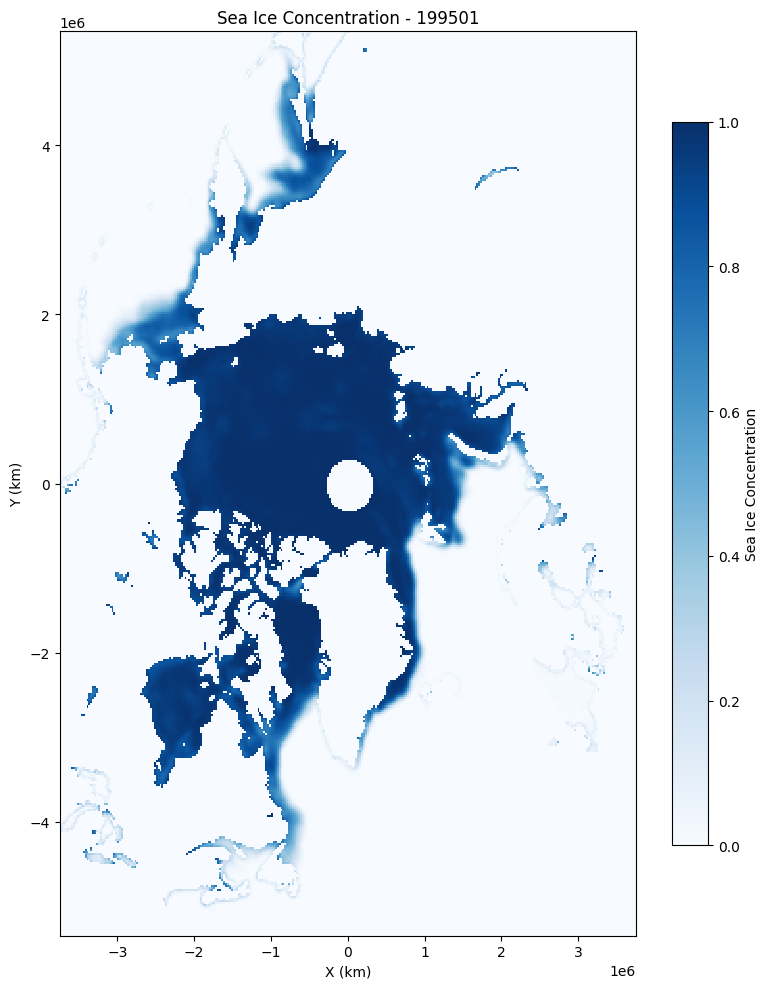

In [18]:
sic_data = loaded_data['sic']
x_coords = loaded_data['x'] 
y_coords = loaded_data['y']
date_info = loaded_data['dates']

plt.figure(figsize=(8, 10))

time_idx = 0
sic_plot = sic_data[time_idx]

X, Y = np.meshgrid(x_coords, y_coords)
im = plt.pcolormesh(X, Y, sic_plot, cmap='Blues', vmin=0, vmax=1, shading='auto')

plt.colorbar(im, label='Sea Ice Concentration', shrink=0.8)
plt.title(f'Sea Ice Concentration - {dates[time_idx]}')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.tight_layout()
plt.show()

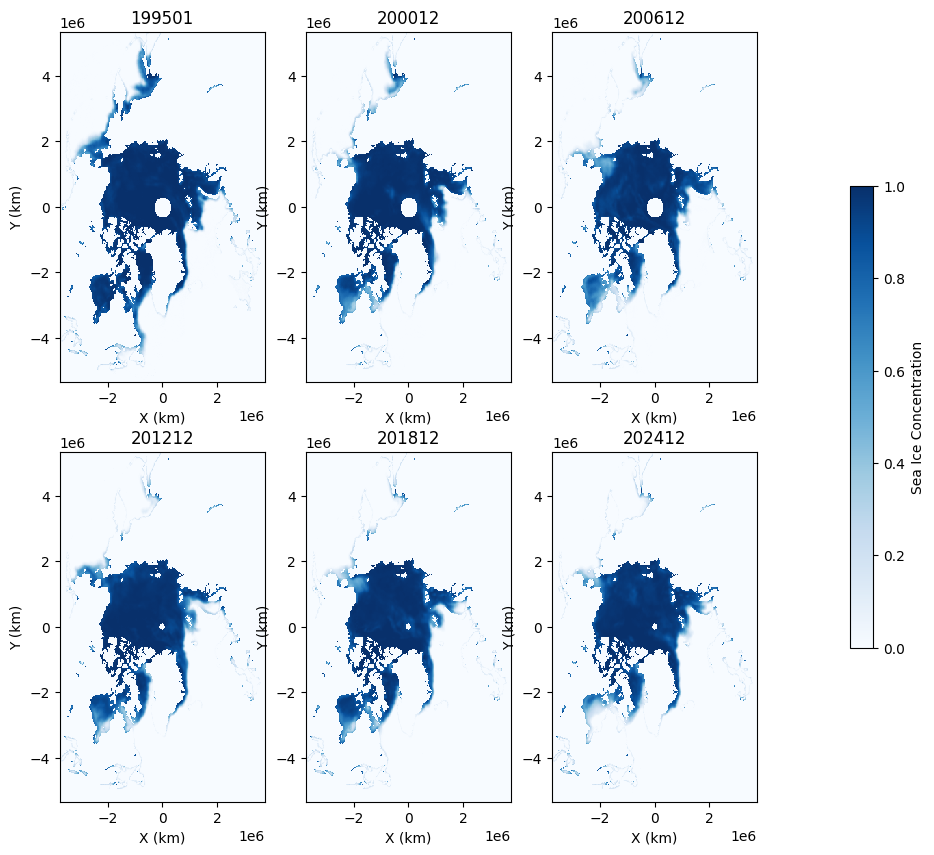

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()

time_indices = np.linspace(0, len(sic_data) - 1, 6, dtype=int)

for i, time_idx in enumerate(time_indices):
    ax = axes[i]
    sic_plot = sic_data[time_idx]
    
    pcm = ax.pcolormesh(X, Y, sic_plot, cmap='Blues', vmin=0, vmax=1, shading='auto')
    
    ax.set_title(f'{dates[time_idx]}')
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')

# 공통 컬러바 추가
cbar = fig.colorbar(pcm, ax=axes, shrink=0.6, pad=0.1)
cbar.set_label('Sea Ice Concentration')

plt.show()